In [368]:
import numpy as np
import matplotlib.pyplot as plt
import freud
import pickle
from Definition_new_method import *
from Variables_new_method import *
from scipy.ndimage import uniform_filter1d
from scipy.stats import binned_statistic
from scipy import interpolate
from shapely.geometry import Point, Polygon
from scipy.spatial.distance import pdist, cdist
import re
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Transfer Data

In [273]:
# data = get_frames_from_xyz('path', ncols = 4, skipcol = 0)
# with open('path', 'wb') as file:
#     pickle.dump(data, file)

# Data Collection

In [369]:
with open('10200.pickle', 'rb') as file: # x , y , group_number , voronoi_area
    data = pickle.load(file)
print ('number of frames = ', data.shape[0], '\nparticle numbers = ', data.shape[1], '\nbox size = ', box_size)

number of frames =  600 
particle numbers =  10200 
box size =  [ 85 170]


# Choose time range

In [370]:
chosen_data = []
for i in range (initial_frame_number, len(data)-every_frame, every_frame):
    chosen_data.append(data[i])
chosen_data = np.array(chosen_data, dtype = object)
print('frame number:', len(chosen_data))

frame number: 299


### Raw interfaces

In [371]:
raw_interfaces_frames = []
for frame in chosen_data:
    interfaces = []
    interface_pos = frame[(frame[:,2] == 1) & (frame[:,3] > voronoi_cutoff)][:,:2]
    interface1 = interface_pos[interface_pos[:,1] > (np.max(interface_pos[:,1]) - np.min(interface_pos[:,1]))/2]
    interface2 = interface_pos[interface_pos[:,1] < (np.max(interface_pos[:,1]) - np.min(interface_pos[:,1]))/2]
    interfaces.append(interface1); interfaces.append(interface2)
#     interfaces = np.array(interfaces)
    raw_interfaces_frames.append(interfaces)
#     plt.plot(*interface1.T, 'o', ms = 1)
#     plt.plot(*interface2.T, 'o', ms = 1)
#     plt.show()
raw_interfaces_frames = np.array(raw_interfaces_frames, dtype = object)

### Sorted interfaces

In [372]:
sorted_interfaces_frames = []
for frame in raw_interfaces_frames:
    sorted_interfaces = []
    for interface in frame:
        sorted_interface = sort_particles(interface, 20)
        sorted_interfaces.append(sorted_interface)
#         plt.plot(*sorted_interface.T, '-o', ms= 4)
#     plt.show()
    sorted_interfaces_frames.append(sorted_interfaces)
sorted_interfaces_frames = np.array(sorted_interfaces_frames, dtype = object)

### Mean interfaces and Interfacial particles

In [373]:
mean_interfaces_frames = []; interfacial_particles_frames = []
for interfaces_frame in sorted_interfaces_frames:
    mean_interfaces = []; interfacial_particles = []
    for interface in interfaces_frame:
        mean_interface = get_mean_interpolated_interface(np.array(interface, dtype = float), 10)
        mean_interfaces.append(mean_interface)
        x_area = [np.max(mean_interface[:,0]), np.min(mean_interface[:,0])]
        interfacial_particle = interface[(interface[:,0] < x_area[0]) & (interface[:,0] > x_area[1])]
        interfacial_particles.append(interfacial_particle)
#         plt.plot(*mean_interface.T, c = 'k')
#         plt.plot(*interfacial_particle.T, 'o', ms = 4)
#     plt.show()
    mean_interfaces_frames.append(mean_interfaces)
    interfacial_particles_frames.append(interfacial_particles)
mean_interfaces_frames = np.array(mean_interfaces_frames, dtype = object)
interfacial_particles_frames = np.array(interfacial_particles_frames, dtype = object)

## HH Correlation Function and Height PDF

In [390]:
total_h = []
HH_total = []
bins = np.linspace(0, 5, 30)
for mean_interfaces_frame, particles_frame in zip(mean_interfaces_frames, interfacial_particles_frames):
    for mean_interface, particle in zip(mean_interfaces_frame, particles_frame):
        distance = cdist(particle, mean_interface)
        height = distance.min(axis = 1)
        height_sign = np.ones(len(height), dtype = int)
        for i, p in enumerate(particle):
            x = p[0]
            d = abs(mean_interface[:,0]-x)
            proj_index = np.argmin(d)
            if p[1] < mean_interface[proj_index][1]:
                height_sign[i] *= -1
        total_h.append(height *height_sign)
    #     print(mean_interface.shape, particles.shape)
        # HH correlation
        HH = hh_corr_cluster(np.array(particle, dtype = np.float32), np.array(mean_interface, dtype = np.float32), height * height_sign, bins)
        HH_total.append(HH)
total_h = [x for y in total_h for x in y]
total_h = np.array(total_h, dtype = object)

### HH Correlation plot

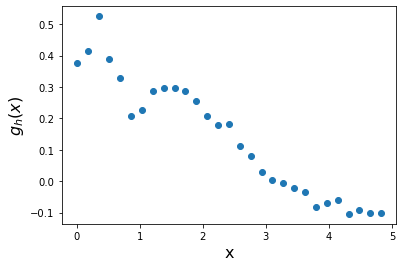

In [393]:
HH_average = np.nanmean(HH_total, axis = 0)
plt.plot(bins[:-1],HH_average, 'o'); plt.xlabel('x', fontsize = 16); plt.ylabel('$g_h(x)$', fontsize = 16)
plt.show()
# plt.savefig('Sim_HH_1.png',dpi=300)

### Height PDF plot

Training data =  26723


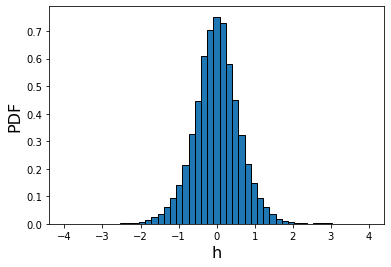

In [389]:
plt.hist(total_h, bins = np.linspace(-4,4,50), ec = 'k', density = True); plt.xlabel('h', fontsize = 16); plt.ylabel('PDF', fontsize = 16)
plt.show()
# plt.savefig('Sim_HPDF.png', dpi = 300)
print('Training data = ', len(total_h))

# single frame for checking

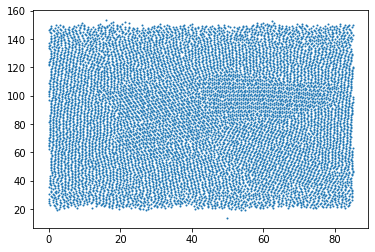

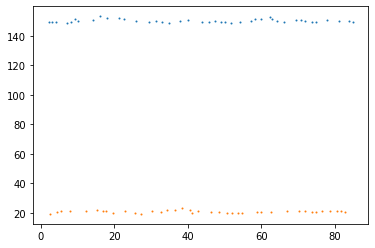

In [68]:
interfaces = []
single_frame = data[200]
pos = single_frame[:,:2]
plt.plot(*pos.T, 'o', ms = 1); plt.show()
interface_pos = pos [(single_frame[:,2] == 1) & (single_frame[:,3] > voronoi_cutoff)]
interface1 = interface_pos[interface_pos[:,1] > (np.max(interface_pos[:,1]) - np.min(interface_pos[:,1]))/2]
interface2 = interface_pos[interface_pos[:,1] < (np.max(interface_pos[:,1]) - np.min(interface_pos[:,1]))/2]
interfaces.append(interface1); interfaces.append(interface2)
interfaces = np.array(interfaces, dtype = object)
for interface in interfaces:
    plt.plot(*interface.T, 'o', ms = 1)
plt.show()

In [84]:
sorted_interfaces = []
for interface in interfaces:
    sorted_interfaces.append(sort_particles(interface, 20))
sorted_interfaces = np.array(sorted_interfaces, dtype = object)

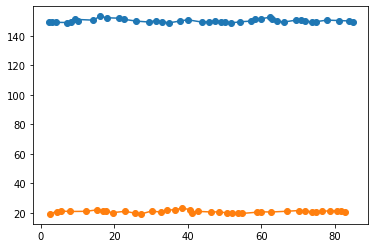

In [110]:
for interface in sorted_interfaces:
    plt.plot(*interface.T, '-o')

In [246]:
mean_interfaces = []; interfacial_particles = []
for interface in sorted_interfaces:
    mean_interface = get_mean_interpolated_interface(interface, 10)
    mean_interfaces.append(mean_interface)
    x_area = [np.max(mean_interface[:,0]), np.min(mean_interface[:,0])]
    interfacial_particles.append(interface[(interface[:,0] < x_area[0]) & (interface[:,0] > x_area[1])])
mean_interfaces = np.array(mean_interfaces, dtype = object)
interfacial_particles = np.array(interfacial_particles, dtype = object)

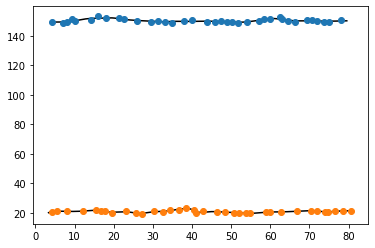

In [247]:
%matplotlib inline
for mean_interface, interfacial_particle in zip(mean_interfaces, interfacial_particles):
    plt.plot(*mean_interface.T, ms = 1, c = 'k')
    plt.plot(*interfacial_particle.T, 'o')

In [268]:
total_h = []
HH_total = []
bins = np.linspace(0, 40, 5)
for mean_interface, particles in zip(mean_interfaces, interfacial_particles):
    distance = cdist(particles, mean_interface)
    height = distance.min(axis = 1)
    height_sign = np.ones(len(height), dtype = int)
    for i, p in enumerate(particles):
        x = p[0]
        d = abs(mean_interface[:,0]-x)
        proj_index = np.argmin(d)
        if p[1] < mean_interface[proj_index][1]:
            height_sign[i] *= -1
    total_h.append(height *height_sign)
#     print(mean_interface.shape, particles.shape)
    # HH correlation
    HH = hh_corr_cluster(particles, mean_interface, height * height_sign, bins)
    HH_total.append(HH)
total_h = [x for y in total_h for x in y]
total_h = np.array(total_h, dtype = object)

In [269]:
print(HH_total)

[array([ 0.04343642, -0.02124355,  0.01826602,  0.00173304]), array([ 0.00781278,  0.00237819, -0.00090507,  0.00028546])]


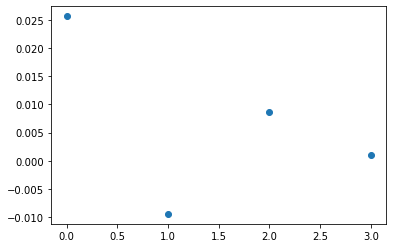

In [270]:
HH_average = np.nanmean(HH_total, axis = 0)
plt.plot(HH_average, 'o')

(array([ 2.,  3.,  7., 11., 21., 15.,  7.,  3.,  1.,  3.]),
 array([-1.1629862208716721, -0.9134196088060411, -0.66385299674041,
        -0.41428638467477885, -0.16471977260914783, 0.08484683945648319,
        0.33441345152211444, 0.5839800635877455, 0.8335466756533765,
        1.0831132877190077, 1.3326798997846387], dtype=object),
 <BarContainer object of 10 artists>)

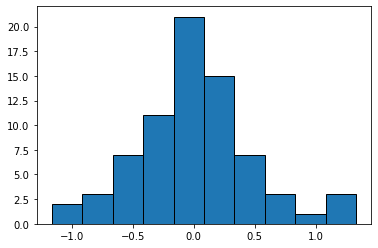

In [264]:
plt.hist(total_h, ec = 'k')